In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



## Motivation

### Why the Enron Dataset?
Enron Corporation was established in 1985 through the merger of Houston Natural Gas and InterNorth, positioning itself as a major player in the energy sector . By the end of 2000, Enron's stock price had soared to $83.13, giving the company a market capitalization exceeding $60 billion . However, on December 2, 2001, Enron filed for Chapter 11 bankruptcy protection, marking one of the largest corporate bankruptcies in U.S. history, and more than 25000 people lost their job, aswell as thousands of shareholders lost their money.

Subsequent investigations uncovered extensive accounting fraud and insider trading within the company. As part of the legal proceedings, the Federal Energy Regulatory Commission (FERC) released a vast collection of Enron's internal emails, spanning from 1998 to 2002. This dataset, comprising approximately 500,000 emails from about 150 users—primarily senior management—was later curated and made publicly available by the CALO Project at Carnegie Mellon University .

The Enron email dataset has since become a valuable resource for researchers studying organizational communication, social network analysis, and natural language processing (NLP). We chose this dataset due to the significant impact of the Enron scandal and our interest in exploring whether NLP techniques can help identify key individuals and patterns indicative of fraudulent behavior. Such methods hold promise for enhancing fraud detection mechanisms in corporate settings.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import networkx as nx
import nxviz as nv


/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


### The dataset and datacleaning

The Enron dataset is incredibly large. It contains more than 500,000 emails from more than 5000 employees. However, some emails does not contain any value and therefor it has to be cleaned. To do this, we have inccoperated some filtering to obtain a better quality version.

Since the dataset is so big, we were forced to take a random subset of the dataset. We experimented with different values, but settled with 250000 emails

In [53]:
pd.options.mode.chained_assignment = None

data = pd.read_csv('../emails.csv')
data = data.sample(n=250000, random_state=7)  # Using random_state for reproducibility

data.info()




<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 467237 to 309418
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     250000 non-null  object
 1   message  250000 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [54]:
def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
    """returns a specified email address from each row in a Series"""
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df


In [55]:
x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data = standard_format(data, data.message, v, i)
data = data.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(data.index), np.round(((x - len(data.index)) / x) * 100, decimals=2)))


Got rid of 53975 useless emails! That's 21.59% of the total number of messages in this dataset.


In [56]:
import re

# 1) Split each message into 16 columns (0–15): the first 15 header lines + “the rest”
split_cols = data['message'].str.split(pat='\n', n=15, expand=True)

# 2) Extract the bits you want
data = data.assign(
    date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
    sender     = split_cols[2].str.replace('From: ',   '', regex=False),
    recipients = split_cols[3].str.replace('To: ',     '', regex=False),
    subject    = split_cols[4].str.replace('Subject: ','', regex=False),
    text       = split_cols[15]  # everything after the 15th newline
)

# 3) Pull out up to three “To:” addresses
addr_re = r'[\w\.-]+@[\w\.-]+\.\w+'
all_to_addrs = data['recipients'].str.findall(addr_re)
data['recipient1'] = all_to_addrs.str.get(0)
data['recipient2'] = all_to_addrs.str.get(1)
data['recipient3'] = all_to_addrs.str.get(2)

# 4) Pull out exactly one “From:” address
data['sender'] = data['sender'].str.extract(f'({addr_re})')[0]

# 5) Filter to internal Enron senders & first recipient
mask = data['sender'].str.endswith('@enron.com', na=False) & \
       data['recipient1'].str.endswith('@enron.com', na=False)
data = data[mask]

# 6) Keep only “active” senders (>50 emails)
send_counts = data['sender'].value_counts()
active    = send_counts[send_counts > 50].index
data = data[data['sender'].isin(active)]

# 7) Reorder & reset index
data = data[['date','sender','recipient1','subject','text']] \
           .reset_index(drop=True)

bad_keywords = [
    r"payroll",      # payroll.message@enron.com, etc.
    r"services",     # wholesale.services@enron.com, etc.
    r"mailout",      # xyz.mailout@enron.com
    r"list",         # enron.list@enron.com, all.list@enron.com
    r"distribution", # distribution@enron.com
    r"announcement", # ect.announcement, enron.announcements
    r"team\.",       # team.artesia, team.flagstaff-sta2
    r"dl-ga",        # dl-ga-all_domestic, dl-ga-all_enron_worldwide1
    r"public",       # public.houston, public.relations
    r"all\.",        # all.employees, all.worldwide, all.xms.users
    r"everyone",     # everyone_in_ect_houston
    r"office",       # office.chairman
    r"united",       # united.list, united.way
]
pattern = "(" + "|".join(bad_keywords) + ")"

# filter them out
good = (~data['sender']    .str.contains(pattern, case=False, na=False)
      & ~data['recipient1'].str.contains(pattern, case=False, na=False))
data = data[good].reset_index(drop=True)


recv_counts = data['recipient1'].value_counts()

# step 6.6) find those who both send >50 AND receive >50
active_senders   = send_counts[ send_counts   > 50 ].index
active_receivers = recv_counts[ recv_counts  > 50 ].index

active_both = active_senders.intersection(active_receivers)

# step 6.7) filter to only those senders
data = data[ data['sender'].isin(active_both) ]

# now you can do your reorder & reset index (step 7)
self_mask = data['sender'] == data['recipient1']
data = data[~self_mask]

# now reorder & reset index (again)
data = data[['date','sender','recipient1','subject','text']] \
           .reset_index(drop=True)

send_counts = data['sender'].value_counts()
recv_counts = data['recipient1'].value_counts()

active_senders   = set(send_counts[send_counts   > 50].index)
active_receivers = set(recv_counts[recv_counts   > 50].index)

# 1) Only keep edges where BOTH endpoints are active
active_both = active_senders & active_receivers

edges = data[
    data['sender'].isin(active_both) &
    data['recipient1'].isin(active_both)
].reset_index(drop=True)

print("Unique senders:", edges['sender'].nunique())
print("Unique recipients:", edges['recipient1'].nunique())
print("Total edges:", len(edges))




/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_63867/1285257217.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_63867/1285257217.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  date       = pd.to_datetime( split_cols[1].str.replace('Date: ', '', regex=False) ),
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_63867/1285257217.py:57: UserWarning: This pattern is interpreted as a regular expression, and has m

Unique senders: 197
Unique recipients: 197
Total edges: 35589


['evelyn.metoyer@enron.com', 'kate.symes@enron.com', 'john.griffith@enron.com', 'dutch.quigley@enron.com', 'robert.bruce@enron.com', 'sara.shackleton@enron.com', 'jeffrey.shankman@enron.com', 'john.arnold@enron.com', 'sherri.sera@enron.com', 'greg.whalley@enron.com', 'shari.stack@enron.com', 'leslie.hansen@enron.com', 'kay.mann@enron.com', 'ben.jacoby@enron.com', 'suzanne.adams@enron.com', 'mark.haedicke@enron.com', 'paul.simons@enron.com', 'tana.jones@enron.com', 'david.delainey@enron.com', 'mark.taylor@enron.com', 'alan.aronowitz@enron.com', 'stacy.dickson@enron.com', 'steven.kean@enron.com', 'maureen.mcvicker@enron.com', 'mary.hain@enron.com', 'susan.mara@enron.com', 'sally.beck@enron.com', 'greg.piper@enron.com', 'richard.sanders@enron.com', 'andrew.edison@enron.com', 'drew.fossum@enron.com', 'susan.scott@enron.com', 'mike.jordan@enron.com', 'rick.buy@enron.com', 'jeffery.fawcett@enron.com', 'sheila.tweed@enron.com', 'tanya.rohauer@enron.com', 'mike.maggi@enron.com', 'michelle.nels

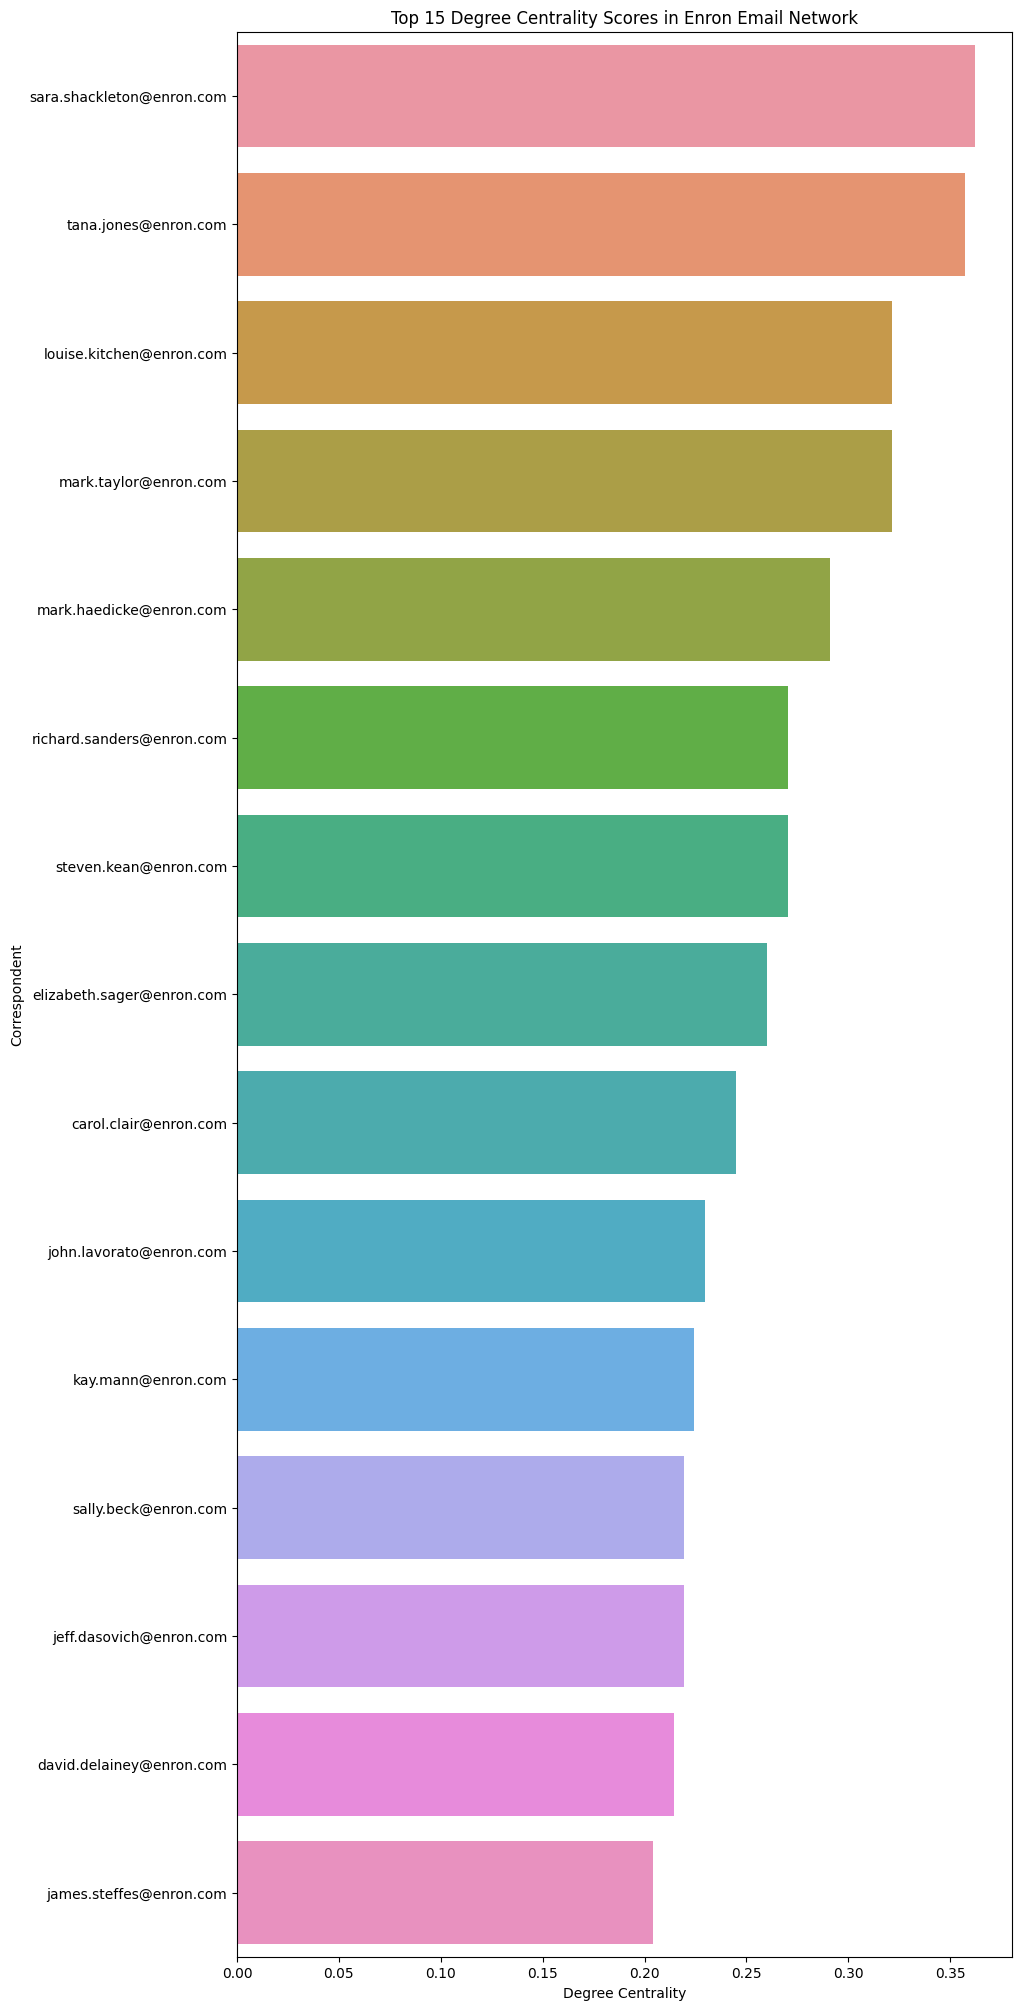

In [57]:
G = nx.from_pandas_edgelist(edges, 'sender', 'recipient1', edge_attr=['date', 'subject'])

cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 25))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
print(G.nodes())
print(len(G.nodes()))
plt.savefig('images/centrality.png')



sent_counts = data.groupby('sender').size().rename('sent_count')

# 2. Count number of emails received per person
recv_counts = data.groupby('recipient1').size().rename('recv_count')

# 3. Merge those two counts into one table
counts = pd.concat([sent_counts, recv_counts], axis=1).fillna(0).astype(int)

# 4. Select only those with ≥50 sent AND ≥50 received


# 5. Filter your node list




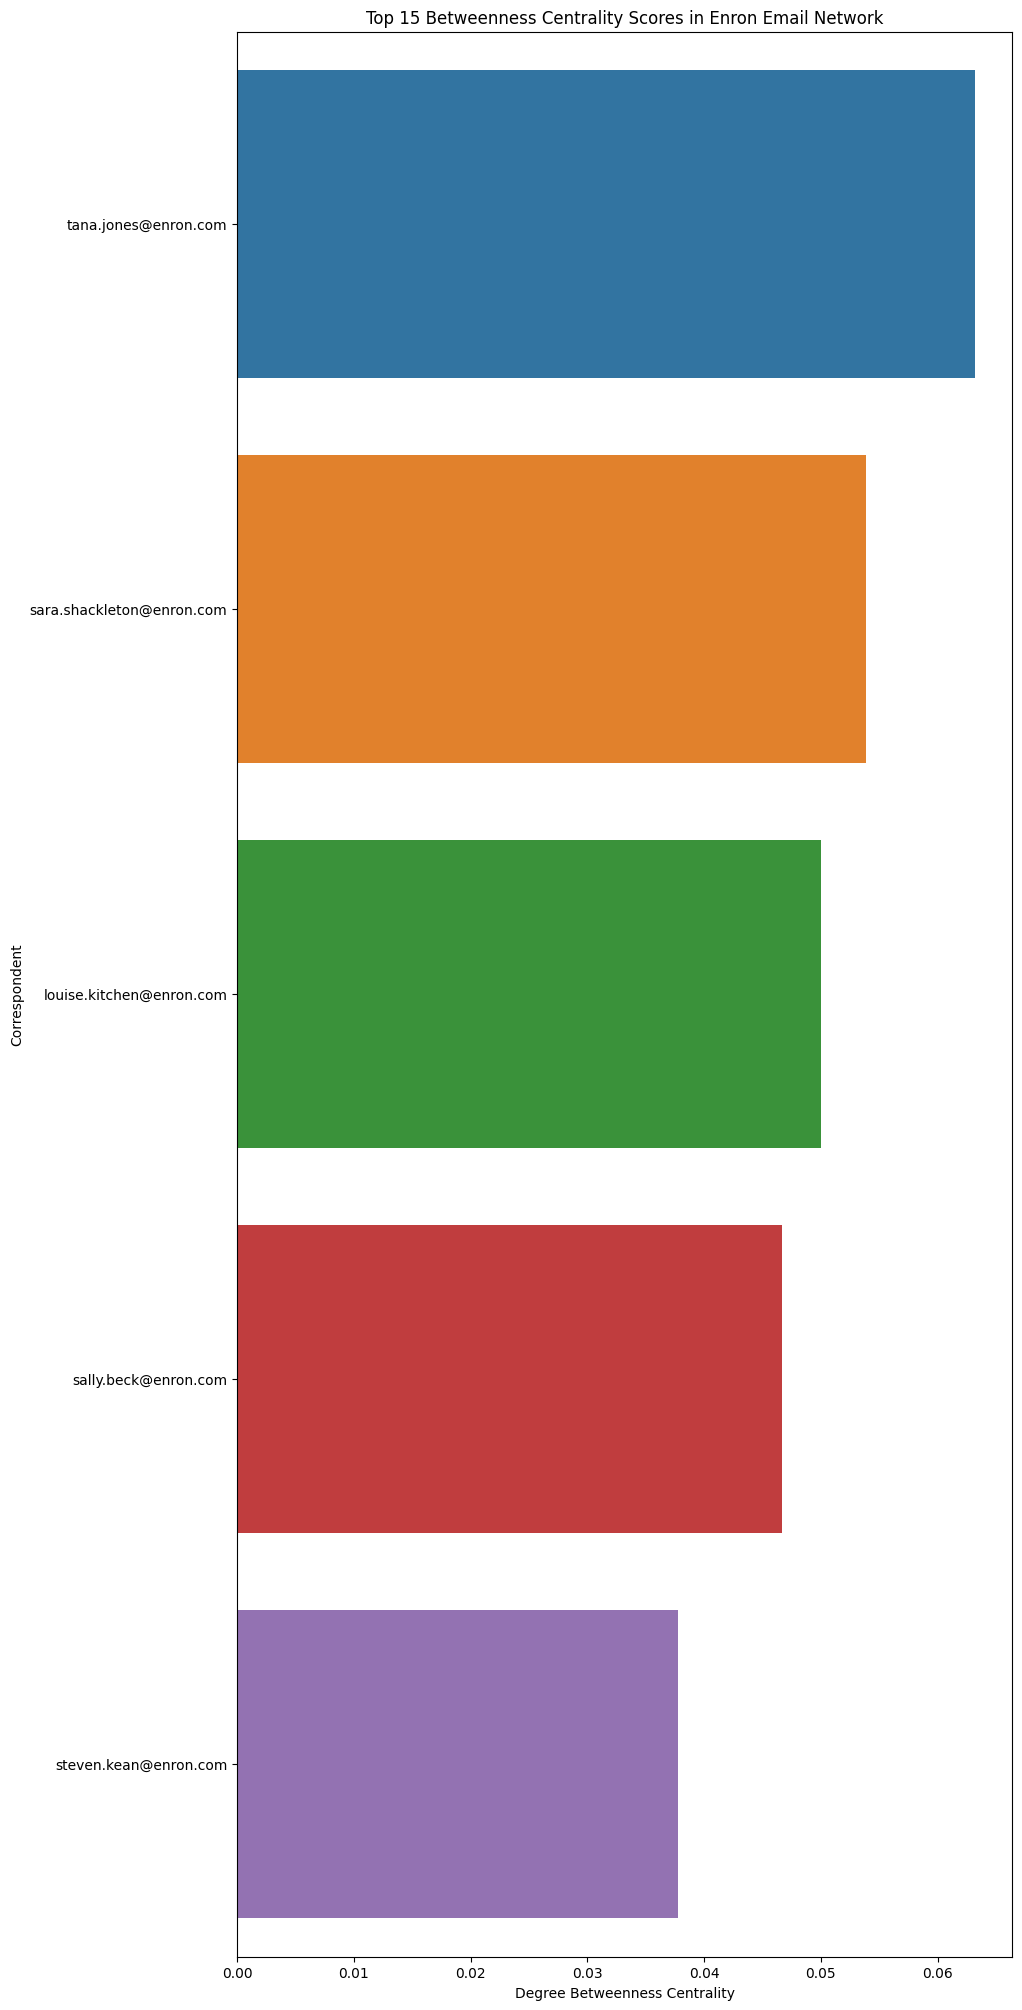

<Figure size 640x480 with 0 Axes>

In [58]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(10, 25))
_ = sns.barplot(x='betweenness', y='name', data=bet[:5], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Enron Email Network')
plt.show()
plt.savefig('images/betweenness.png')

In [59]:
#community detection

# Use Louvain method for community detection
communities = nx.community.louvain_communities(G)

# Print number of communities found
print(f"Number of communities detected: {len(communities)}")

# Create a mapping of node to community number
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Add community information to nodes
nx.set_node_attributes(G, community_map, 'community')

# Print size of each community
print("\nCommunity sizes:")
for i, community in enumerate(communities):
    print(f"Community {i}: {len(community)} nodes")

# Visualize top 5 largest communities
community_sizes = [len(c) for c in communities]
top_5_indices = sorted(range(len(community_sizes)), key=lambda k: community_sizes[k], reverse=True)[:5]

plt.figure(figsize=(10, 25))
for idx in top_5_indices:
    community = communities[idx]
    subgraph = G.subgraph(community)
    print(f"\nTop 5 central nodes in community {idx}:")
    # Get degree centrality for nodes in this community
    deg_cent = nx.degree_centrality(subgraph)
    top_nodes = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    for node, centrality in top_nodes:
        print(f"{node}: {centrality:.3f}")


Number of communities detected: 6

Community sizes:
Community 0: 40 nodes
Community 1: 7 nodes
Community 2: 15 nodes
Community 3: 45 nodes
Community 4: 31 nodes
Community 5: 59 nodes

Top 5 central nodes in community 5:
tana.jones@enron.com: 0.879
sara.shackleton@enron.com: 0.879
mark.taylor@enron.com: 0.828
carol.clair@enron.com: 0.690
elizabeth.sager@enron.com: 0.603

Top 5 central nodes in community 3:
louise.kitchen@enron.com: 0.568
sally.beck@enron.com: 0.545
john.lavorato@enron.com: 0.545
vince.kaminski@enron.com: 0.523
david.delainey@enron.com: 0.477

Top 5 central nodes in community 0:
jeff.dasovich@enron.com: 0.692
steven.kean@enron.com: 0.692
james.steffes@enron.com: 0.641
richard.shapiro@enron.com: 0.641
d..steffes@enron.com: 0.487

Top 5 central nodes in community 4:
dan.hyvl@enron.com: 0.467
debra.perlingiere@enron.com: 0.433
gerald.nemec@enron.com: 0.400
stephanie.miller@enron.com: 0.333
kim.ward@enron.com: 0.333

Top 5 central nodes in community 2:
steven.harris@enron.co

<Figure size 1000x2500 with 0 Axes>

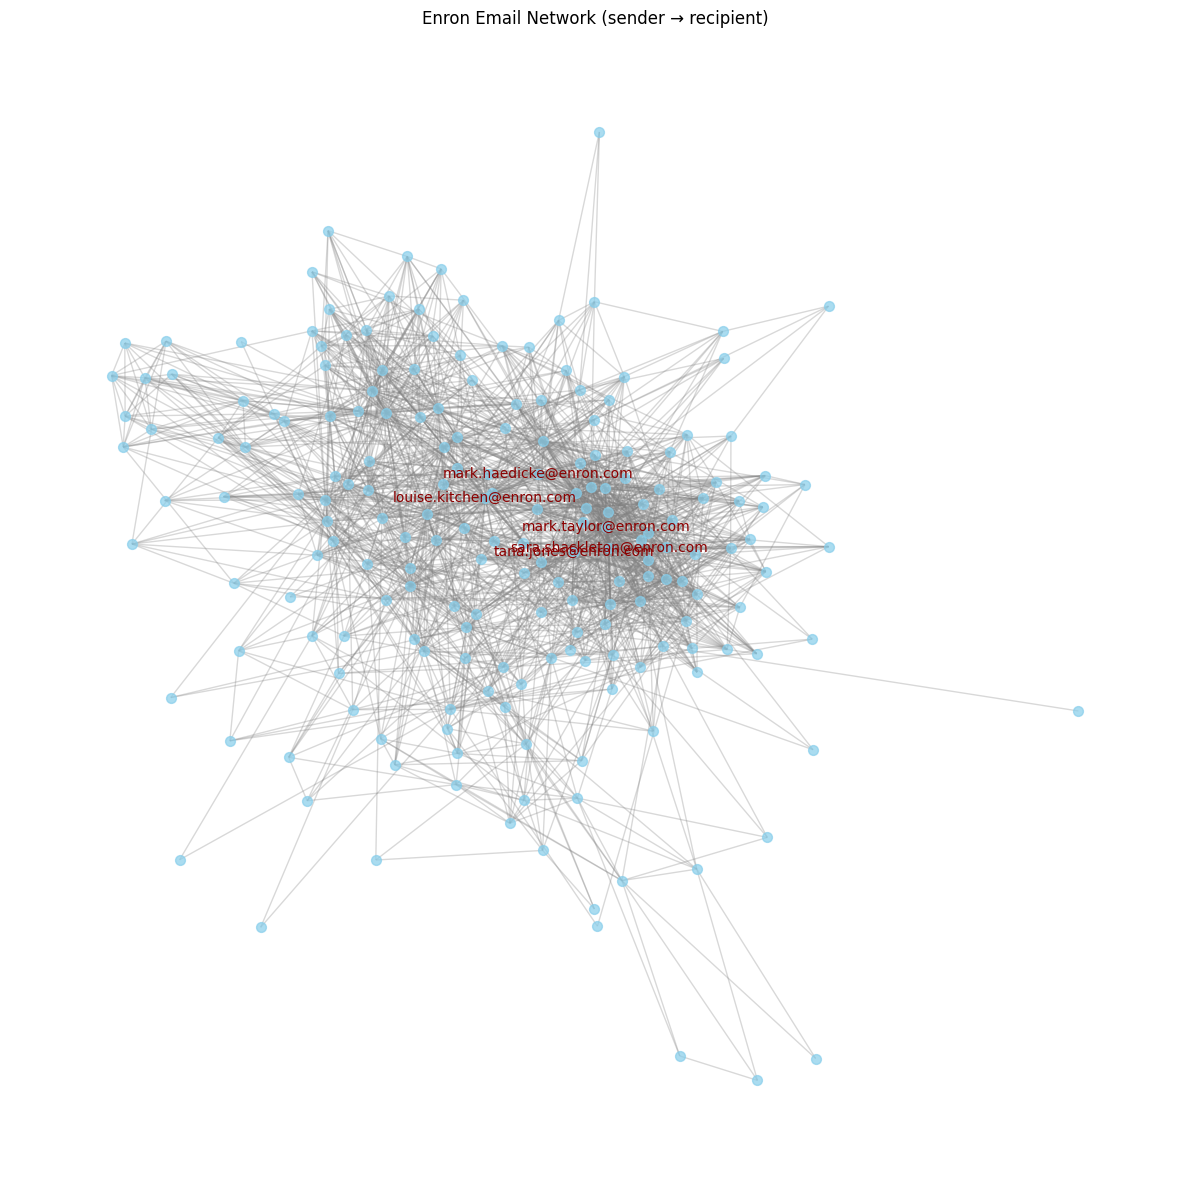

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
import networkx as nx

# 1) Choose a layout (spring is usually a good default for social‐type networks)
pos = nx.spring_layout(G, k=0.1, iterations=50)

# 2) Draw nodes
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(
    G, pos,
    node_size=50,         # tweak to taste
    node_color="skyblue",
    alpha=0.7
)

# 3) Draw edges
nx.draw_networkx_edges(
    G, pos,
    edge_color="gray",
    alpha=0.3
)

# 4) (Optional) Draw labels for the top 5 most‐connected nodes
deg = dict(G.degree())
top5 = sorted(deg, key=deg.get, reverse=True)[:5]
labels = {n: n for n in top5}
nx.draw_networkx_labels(
    G, pos,
    labels,
    font_size=10,
    font_color="darkred"
)

plt.axis("off")
plt.title("Enron Email Network (sender → recipient)")
plt.tight_layout()
plt.show()
plt.savefig('images/networkgraph.png')


In [62]:
print("Phillip Allen sent:", send_counts.get('phillip.allen@enron.com', 0))
print("Phillip Allen recv:", recv_counts.get('phillip.allen@enron.com', 0))
sent_counts

Phillip Allen sent: 560
Phillip Allen recv: 63


5139